In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)

In [5]:
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression

temp_df = all_df.copy()

fare_inlier = temp_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna())]
fare_outlier = temp_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna())]

transformer = PowerTransformer()

X_train = fare_inlier[['Pclass', 'SibSp', 'Parch']]
X_test = fare_outlier[['Pclass', 'SibSp', 'Parch']]
y_train = transformer.fit_transform(fare_inlier.Fare.values.reshape(-1,1))

fare_model = LinearRegression()
fare_model.fit(X_train, y_train)

y_pred = fare_model.predict(X_test)

all_df.loc[(temp_df['Fare'] != 0) & (~temp_df['Fare'].isna()), 'Fare'] = y_train
all_df.loc[(temp_df['Fare'] == 0) | (temp_df['Fare'].isna()), 'Fare'] = y_pred

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

X = fare_inlier[['Pclass', 'SibSp', 'Parch']]
y = transformer.fit_transform(fare_inlier.Fare.values.reshape(-1,1)).ravel()

linear_model = LinearRegression()
print(cross_val_score(linear_model, X, y, cv=10).mean())

rf_model = RandomForestRegressor()
print(cross_val_score(rf_model, X, y, cv=10).mean())

svm_model = SVR()
print(cross_val_score(svm_model, X, y, cv=10).mean())

0.7930653782126456
0.817719808061384
0.806999024833533


In [8]:
from sklearn.preprocessing import OneHotEncoder

sex_encoder = OneHotEncoder(sparse_output=False)
sex_encoded = sex_encoder.fit_transform(all_df[['Sex']])
sex_df = pd.DataFrame(sex_encoded, columns=sex_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, sex_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-1.215092,NaN,S,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.370847,C85,C,1,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.183866,C123,S,1,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-1.025820,NaN,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,-1.025820,NaN,S,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,1.591007,C105,C,1,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,-1.215092,NaN,S,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,-1.025820,NaN,S,0,1


In [9]:
from sklearn.ensemble import RandomForestClassifier

temp_df = all_df.copy()

embarked_inlier = all_df[~all_df['Embarked'].isna()]
embarked_outlier = all_df[all_df['Embarked'].isna()]

X_names = [*sex_encoder.get_feature_names_out(), 'Pclass', 'SibSp', 'Parch', 'Fare']
X_train = embarked_inlier[X_names]
X_test = embarked_outlier[X_names]
y_train = embarked_inlier['Embarked'].values

embark_model = RandomForestClassifier(class_weight='balanced_subsample')
embark_model.fit(X_train, y_train)
y_pred = embark_model.predict(X_test)

all_df.loc[all_df['Embarked'].isna(), 'Embarked'] = y_pred

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

X = embarked_inlier[X_names]
y = embarked_inlier['Embarked'].values

logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
print(cross_val_score(logistic_model, X, y, cv=10).mean())

rf_model = RandomForestClassifier(class_weight='balanced_subsample')
print(cross_val_score(rf_model, X, y, cv=10).mean())

svm_model = SVC(class_weight='balanced')
print(cross_val_score(svm_model, X, y, cv=10).mean())

0.38031708749266
0.8423899001761598
0.4537698179682913


In [11]:
embarked_encoder = OneHotEncoder(sparse_output=False)
embarked_encoded = embarked_encoder.fit_transform(all_df[['Embarked']])
embarked_df = pd.DataFrame(embarked_encoded, columns=embarked_encoder.get_feature_names_out(), dtype='int64')
all_df = pd.concat((all_df, embarked_df), axis=1)
all_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-1.215092,NaN,S,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.370847,C85,C,1,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-1.053615,NaN,S,1,0,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.183866,C123,S,1,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-1.025820,NaN,S,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,-1.025820,NaN,S,0,1,0,0,1
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,1.591007,C105,C,1,0,1,0,0
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,-1.215092,NaN,S,0,1,0,0,1
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,-1.025820,NaN,S,0,1,0,0,1


In [12]:
from sklearn.svm import SVR

age_inliers = all_df[~all_df['Age'].isna()]
age_outliers = all_df[all_df['Age'].isna()]

X_train = age_inliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
X_test = age_outliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
y_train = age_inliers['Age'].values

age_model = SVR()
age_model.fit(X_train, y_train)

y_pred = age_model.predict(X_test)

all_df.loc[all_df['Age'].isna(), 'Age'] = y_pred

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

X = age_inliers[['Pclass', 'Fare', 'SibSp', 'Parch']]
y = age_inliers['Age'].values

linear_model = LinearRegression()
print(cross_val_score(linear_model, X, y, cv=10).mean())

rf_model = RandomForestRegressor()
print(cross_val_score(rf_model, X, y, cv=10).mean())

svm_model = SVR()
print(cross_val_score(svm_model, X, y, cv=10).mean())

0.20741935301383457
0.19375147575496274
0.24138908204752813


In [57]:
train_df = all_df.iloc[:891]
train_df = train_df.astype({'Survived': 'int64'})
test_df = all_df.iloc[891:].reset_index(drop=True).drop('Survived', axis=1)

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       111
           1       0.79      0.74      0.76        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



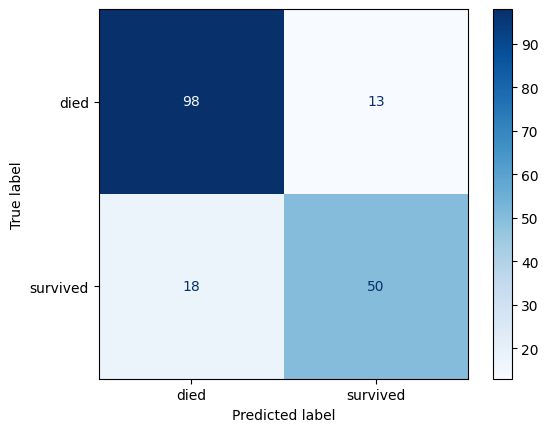

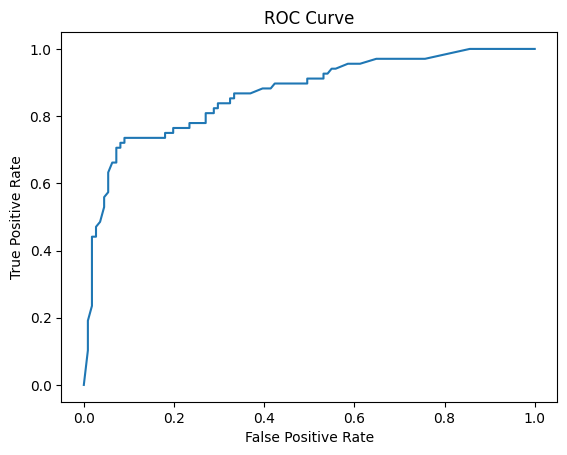

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = train_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
y = train_df['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

logistic_model = RandomForestClassifier(class_weight='balanced_subsample')
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)
y_proba = logistic_model.predict_proba(X_test)

print(metrics.classification_report(y_test, y_pred))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=logistic_model.classes_)
display.plot(cmap='Blues')
x_locs, _ = plt.xticks()
y_locs, _ = plt.yticks()
plt.xticks(x_locs, ['died', 'survived'])
plt.yticks(y_locs, ['died', 'survived'])
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()